# Dependencies

In [1]:
library(ggplot2)
library(iNEXT)
library(parallel)
library(cowplot)
library(ggbeeswarm)

# Functions

In [2]:
histp <- function(df, var){
    myp <- ggplot(data = df, aes(x = eval(parse(text = var)))) + 
    geom_histogram() + myplot + myaxis + labs(x = var)
    return(myp)
}

In [3]:
# From SO to print errors and warnings
safe_mclapply <- function(X, FUN, mc.cores, stop.on.error=T, ...){
  fun <- function(x){
    res_inner <- tryCatch({
      withCallingHandlers(
        expr = {
          FUN(x, ...)
        }, 
        warning = function(e) {
          message_parallel(trimws(paste0("WARNING [element ", x,"]: ", e)))
          # this line is required to continue FUN execution after the warning
          invokeRestart("muffleWarning")
        },
        error = function(e) {
          message_parallel(trimws(paste0("ERROR [element ", x,"]: ", e)))
        }
      )},
      error = function(e){
        # error is returned gracefully; other results of this core won't be affected
        return(e)
      }
    )
    return(res_inner)
  }
  
  res <- mclapply(X, fun, mc.cores=mc.cores, mc.preschedule = FALSE)
  failed <- sapply(res, inherits, what = "error")
  if (any(failed == T)){
    error_indices <- paste0(which(failed == T), collapse=", ")
    error_traces <- paste0(lapply(res[which(failed == T)], function(x) x$message), collapse="\n\n")
    error_message <- sprintf("Elements with following indices failed with an error: %s. Error messages: \n\n%s", 
                             error_indices,
                             error_traces)
    if (stop.on.error)
      stop(error_message)
    else
      warning(error_message, "\n\n### Errors will be ignored ###")
  }
  return(res[!failed])
}

#' Function which prints a message using shell echo; useful for printing messages from inside mclapply when running in Rstudio
message_parallel <- function(...){
  system(sprintf('echo "\n%s\n"', paste0(..., collapse="")))
}

In [4]:
source("/Users/anabbi/git/ped_CapTCRseq/R/ggplot2_theme.R")
source("/Users/anabbi/git/ped_CapTCRseq/R/color_schemes.R")
source("/Users/anabbi/git/ped_CapTCRseq/R/Immune_Diversity.R")

# Paths

In [5]:
datapath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Data/"
plotpath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Plots/"
manifestpath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Manifests/"

gitpath <- "/Users/anabbi/git/ped_CapTCRseq/"

# Main

In [7]:
divstats <- read.csv(paste0(datapath, "capTCRseq/divstats_TRBCHP.csv"), header = T, stringsAsFactors = F, row.names = 1)

In [8]:
emptyids <- sapply(myimmunelist, function(x) length(x) == 0)

In [9]:
myimmunelist <- myimmunelist[!emptyids]

In [10]:
length(myimmunelist)

[1] 580

Run interactively on Samwise and copy bac to local

out <- safe_mclapply(1:length(myimmunelist), function(x){
    iNEXT(myimmunelist[x], c(0,1,2), datatype="abundance", nboot = 50, endpoint = 3505)}, mc.cores = 26)

# Load iNEXT output

In [8]:
load(file = paste0(datapath,"capTCRseq/inext_out_all.RData"))

In [9]:
head(out[1])

[[1]]
Compare 1 assemblages with Hill number order q = .
$class: iNEXT

$DataInfo: basic data information
                      site   n S.obs     SC f1 f2 f3 f4 f5 f6 f7 f8 f9 f10
CHP_315-05-PBMC-DNA site.1 192    25 0.9793  4  2  2  4  4  3  0  1  2   0

$iNextEst: diversity estimates with rarefied and extrapolated samples.
$`CHP_315-05-PBMC-DNA`
       m       method order     qD qD.LCL qD.UCL    SC SC.LCL SC.UCL
1      1 interpolated     0  1.000  1.000  1.000 0.136  0.106  0.165
10    96 interpolated     0 21.846 20.186 23.506 0.942  0.924  0.959
20   192     observed     0 25.000 22.395 27.605 0.979  0.964  0.995
30  1761 extrapolated     0 28.978 16.737 41.219 1.000  0.998  1.002
40  3505 extrapolated     0 28.979 15.794 42.164 1.000  1.000  1.000
41     1 interpolated     1  1.000  1.000  1.000 0.136  0.090  0.181
50    96 interpolated     1 12.168  9.913 14.423 0.942  0.925  0.959
60   192     observed     1 13.126 10.660 15.591 0.979  0.966  0.993
70  1761 extrapolated     1 

get sample names

In [10]:
allnames <- names(out[[1]]$iNextEst)

for(i in 2:length(out)){
    allnames <- c(allnames, names(out[[i]]$iNextEst))
}

In [11]:
head(allnames)

[1] "CHP_315-05-PBMC-DNA" "CHP_350-01-PBMC-DNA" "CHP_350-02-PBMC-DNA"
[4] "CHP_350-03-PBMC-DNA" "CHP_350-04-PBMC-DNA" "CHP_353-02-PBMC-DNA"

# Plot all samples

make a list of plots

In [159]:
listofplots <- lapply(c(1:length(out)), function(x){ 
    p <- ggiNEXT(out[[x]], type=1, color.var ="order") + 
    theme_bw(base_size = 10) + labs(title = allnames[x]) +
theme(plot.title = element_text(size = 5,hjust = 0.5),
     legend.position = "none")})

add names then subset

In [160]:
names(listofplots) <- allnames

In [162]:
library(cowplot)

In [164]:
pdf(paste0(plotpath, "tumor_all_plots.pdf"),
   width = 10, height = 10)
plot_grid(plotlist = listofplots[grepl("FFPE", names(listofplots))], ncol = 5)
dev.off()

pdf 
  2

In [165]:
pdf(paste0(plotpath, "pbmc_all_plots.pdf"),
   width = 30, height = 30)
plot_grid(plotlist = listofplots[grepl("PBMC", names(listofplots))], ncol = 20)
dev.off()

pdf 
  2

In [166]:
pdf(paste0(plotpath, "cfdna_all_plots.pdf"),
   width = 30, height = 30)
plot_grid(plotlist = listofplots[grepl("cfDNA", names(listofplots))], ncol = 20)
dev.off()

Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 21 row(s) containing missing values (geom_path).”
Warning message:
“Removed 2 rows containing missing values (geom_point).”
Warning message:
“Removed 58 row(s) containing missing values (geom_path).”
Warning message:
“Removed 2 rows containing missing values (geom_point).”
Warning message:
“Removed 58 row(s) containing missing values (geom_path).”


pdf 
  2

# Sample lookup

In [31]:
which(grepl("394-01",allnames ))

[1] 355

In [35]:
ls()

[1] "age_pal"                "allnames"               "cluster_col"           
 [4] "cogpal"                 "cohort_col"             "cri_col"               
 [7] "datapath"               "divstats"               "divstats_raref"        
[10] "Divstats.fx"            "gender_pal"             "gitpath"               
[13] "group_col"              "histp"                  "i"                     
[16] "immunelist_adaptive.fx" "immunelistfx"           "manifestpath"          
[19] "message_parallel"       "myaxis"                 "mycnpal"               
[22] "myplot"                 "mysample"               "mysamplename"          
[25] "out"                    "plotpath"               "qd_0"                  
[28] "qd_1"                   "qd_2"                   "race_pal"              
[31] "safe_mclapply"

In [34]:
divstats[ grepl("394_01",divstats$sample_id),]

,TRB,Reads,CPKR,Average_reads,VMR,Max_reads,Singletons,Doubletons,qD,Sample_Coverage,⋯,observed_Simpson,estimated_Simpson,SE_Simpson,sample_id,file,Sample,Group,Patient,Cycle,basename
,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>
CHP_394-01-PBMC-DNA,1,58,17.24138,58,NA,58,0,0,1,1,⋯,1,1,0,CHP_394_01,batch8_14Jan2020/mixcr/clones/CLONES_TRBCHP_394-01-PBMC-DNA.txt,PBMC,CHP,CHP_394,1,CHP_394-01-PBMC-DNA


In [32]:
out[[355]]$iNextEst

m,method,order,qD,SC
<dbl>,<chr>,<dbl>,<dbl>,<dbl>
1,interpolated,0,1,1
4,interpolated,0,1,1
7,interpolated,0,1,1
10,interpolated,0,1,1
13,interpolated,0,1,1
16,interpolated,0,1,1
19,interpolated,0,1,1
22,interpolated,0,1,1
25,interpolated,0,1,1


# Add rarefied/extrapolated div metrics to divstats

In [27]:
head(divstats)

,TRB,Reads,CPKR,Average_reads,VMR,Max_reads,Singletons,Doubletons,qD,Sample_Coverage,⋯,observed_Simpson,estimated_Simpson,SE_Simpson,sample_id,file,Sample,Group,Patient,Cycle,basename
,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>
CHP_315-05-PBMC-DNA,27,659,40.97117,24.407407,1.4380040,187,1,1,27.432,1.000,⋯,9.026,9.138,0.749,CHP_315_05,batch4_19Aug2019/mixcr/clones/CLONES_TRBCHP_315-05-PBMC-DNA.txt,PBMC,CHP,CHP_315,5,CHP_315-05-PBMC-DNA
CHP_350-01-PBMC-DNA,153,1647,92.89617,10.764706,0.7872963,59,5,6,154.893,1.000,⋯,94.691,100.406,3.548,CHP_350_01,batch_reseq_24Feb2020/mixcr/clones/CLONES_TRBCHP_350-01-PBMC-DNA.txt,PBMC,CHP,CHP_350,1,CHP_350-01-PBMC-DNA
CHP_350-02-PBMC-DNA,269,2992,89.90642,11.122677,0.8300771,92,17,5,281.850,0.997,⋯,159.505,168.431,5.211,CHP_350_02,batch_reseq_24Feb2020/mixcr/clones/CLONES_TRBCHP_350-02-PBMC-DNA.txt,PBMC,CHP,CHP_350,2,CHP_350-02-PBMC-DNA
CHP_350-03-PBMC-DNA,207,2134,97.00094,10.309179,0.7807083,52,9,10,210.609,1.000,⋯,128.847,137.062,3.485,CHP_350_03,batch_reseq_24Feb2020/mixcr/clones/CLONES_TRBCHP_350-03-PBMC-DNA.txt,PBMC,CHP,CHP_350,3,CHP_350-03-PBMC-DNA
CHP_350-04-PBMC-DNA,106,989,107.17897,9.330189,0.7731222,34,10,2,114.239,0.993,⋯,66.580,71.313,2.548,CHP_350_04,batch_reseq_24Feb2020/mixcr/clones/CLONES_TRBCHP_350-04-PBMC-DNA.txt,PBMC,CHP,CHP_350,4,CHP_350-04-PBMC-DNA
CHP_353-02-PBMC-DNA,16,234,68.37607,14.625000,0.5897147,35,1,0,16.000,1.000,⋯,12.066,12.668,0.655,CHP_353_02,batch_reseq_24Feb2020/mixcr/clones/CLONES_TRBCHP_353-02-PBMC-DNA.txt,PBMC,CHP,CHP_353,2,CHP_353-02-PBMC-DNA


In [14]:
#get sample names in inext output
allnames <- names(out[[1]]$iNextEst)
for(i in 2:length(out)){
    allnames <- c(allnames, names(out[[i]]$iNextEst))
}

In [29]:
summary(divstats$Reads)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
     1.0    841.8   3088.5  18710.4  12587.8 363060.0 

In [28]:
tapply(divstats$Reads, divstats$Sample, summary)

$cfDNA
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      1     356    2962    6515    7858   88874 

$PBMC
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
    10.0    999.5   3209.5  31264.2  26991.2 363060.0 

$Tumor
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    763    1291    3064    9136   16927   29465 


In [15]:
divstats_raref <- divstats

In [16]:
divstats_raref$qD_0_3505 <- NA
divstats_raref$qD_1_3505 <- NA
divstats_raref$qD_2_3505 <- NA

In [17]:
for(i in 1:length(allnames)){
    mysample <- out[[i]]$iNextEst[[1]]
    mysamplename <- allnames[i]
    
    qd_0 <- mysample[ mysample$order == 0 & mysample$m == 3505,"qD"]
    qd_1 <- mysample[ mysample$order == 1 & mysample$m == 3505,"qD"]
    qd_2 <- mysample[ mysample$order == 2 & mysample$m == 3505,"qD"]
    
    divstats_raref$qD_0_3505[ match(mysamplename, rownames(divstats_raref))] <- qd_0
    divstats_raref$qD_1_3505[ match(mysamplename, rownames(divstats_raref))] <- qd_1
    divstats_raref$qD_2_3505[ match(mysamplename, rownames(divstats_raref))] <- qd_2
}

In [18]:
colnames(divstats_raref)

[1] "TRB"                "Reads"              "CPKR"              
 [4] "Average_reads"      "VMR"                "Max_reads"         
 [7] "Singletons"         "Doubletons"         "qD"                
[10] "Sample_Coverage"    "observed_Richness"  "estimated_Richness"
[13] "SE_Richeness"       "observed_Shannon"   "estimated_Shannon" 
[16] "SE_Shannon"         "observed_Simpson"   "estimated_Simpson" 
[19] "SE_Simpson"         "sample_id"          "file"              
[22] "Sample"             "Group"              "Patient"           
[25] "Cycle"              "basename"           "qD_0_3505"         
[28] "qD_1_3505"          "qD_2_3505"

In [19]:
summary(divstats_raref$qD_1_3505)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max.     NA's 
   1.000    3.702   13.439   77.983   89.831 1106.105        1 

In [20]:
summary(divstats_raref$observed_Shannon)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    3.61   13.28   81.62   88.80 1526.86 

In [21]:
summary(divstats_raref$estimated_Shannon)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    3.68   13.43   84.18   91.54 1539.29 

Warning message:
“Removed 1 rows containing missing values (geom_point).”


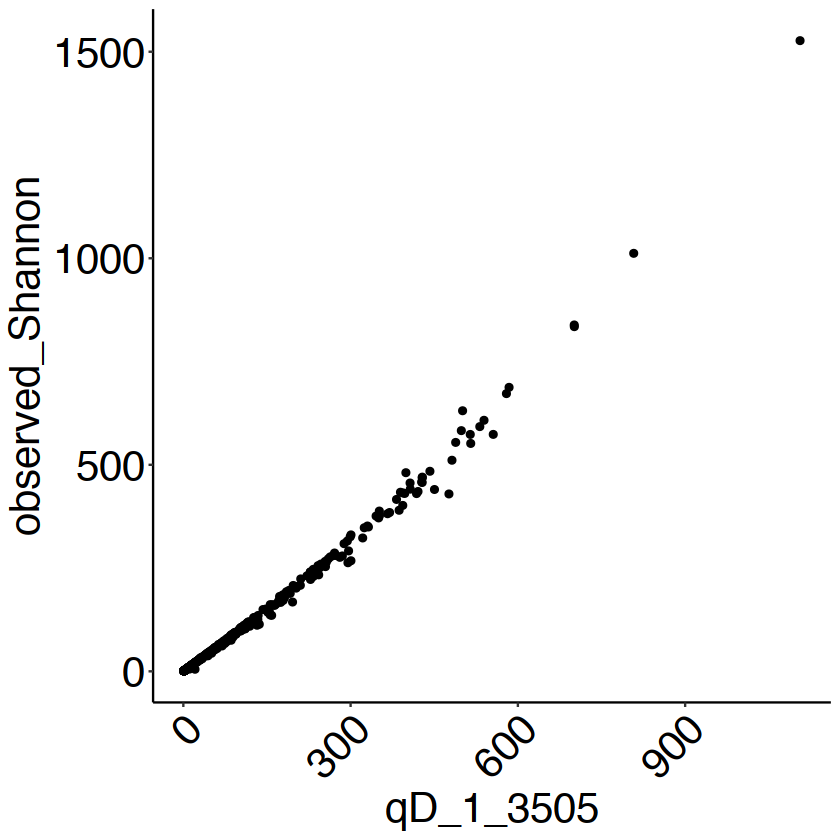

In [22]:
ggplot(data = divstats_raref, aes( x = qD_1_3505, y = observed_Shannon) ) + geom_point() + myplot + myaxis

In [ ]:
write.csv(divstats_raref,
          paste0(datapath, "capTCRseq/divstats_TRBCHP_raref.csv"), row.names = TRUE)

# Plot rarefied and asymp div for baseline PBMC

In [20]:
metadata <- read.csv(file = paste0(datapath, "INT_metadata_flow.csv"),header = T, stringsAsFactors = F)

In [21]:
head(metadata)

,Patient,cycle,FOLD,ATC,Age,Disease_type,TE_fold,Pass,CD3,EM,⋯,CTLA4,PD1.,PDL1.,LAG3.,TIM3.,CTLA4.,Any.NCR,PD1...LAG3...TIM3,group,sample_id
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<lgl>,<int>,<int>,⋯,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,CHP_330,1,0.9,0,5,OS,0.9,NA,2437,24,⋯,NA,4.636849,NA,2.749282,4.636849,NA,NA,NA,Solid,CHP_330_01
2,CHP_330,2,1.9,0,5,OS,1.9,NA,2425,21,⋯,NA,21.855670,NA,11.752577,21.855670,NA,NA,NA,Solid,CHP_330_02
3,CHP_330,3,1.5,0,5,OS,1.5,NA,544,17,⋯,NA,Inf,NA,Inf,Inf,NA,NA,NA,Solid,CHP_330_03
4,CHP_330,4,4.1,0,5,OS,4.1,NA,2484,125,⋯,NA,8.776167,NA,1.610306,8.776167,NA,NA,NA,Solid,CHP_330_04
5,CHP_330,5,6.2,0,5,OS,6.2,NA,0,NA,⋯,NA,-Inf,NA,-Inf,-Inf,NA,NA,NA,Solid,CHP_330_05
6,CHP_331,1,0.0,0,5,SR ALL,0,NA,0,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,Leukemia,CHP_331_01


In [22]:
head(divstats_raref)

,TRB,Reads,CPKR,Average_reads,VMR,Max_reads,Singletons,Doubletons,qD,Sample_Coverage,⋯,estimated_Simpson,SE_Simpson,Sample,Group,Patient,Cycle,sample_id,qD_0_3505,qD_1_3505,qD_2_3505
,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>
CHP_315-05-PBMC-DNA,25,192,130.20833,7.680000,1.6157205,63,4,2,27.519,0.992,⋯,7.367,1.066,PBMC,CHP,CHP_315,5,CHP_315_05,28.979,14.196,7.353
CHP_350-01-PBMC-DNA,153,1647,92.89617,10.764706,0.7872963,59,5,6,154.893,1.000,⋯,100.406,3.380,PBMC,CHP,CHP_350,1,CHP_350_01,154.943,123.759,97.637
CHP_350-02-PBMC-DNA,269,2992,89.90642,11.122677,0.8300771,92,17,5,281.850,0.997,⋯,168.431,5.344,PBMC,CHP,CHP_350,2,CHP_350_02,271.772,209.843,160.752
CHP_350-03-PBMC-DNA,207,2134,97.00094,10.309179,0.7807083,52,9,10,210.609,1.000,⋯,137.062,3.637,PBMC,CHP,CHP_350,3,CHP_350_03,210.077,163.577,131.940
CHP_350-04-PBMC-DNA,106,989,107.17897,9.330189,0.7731222,34,10,2,114.239,0.993,⋯,71.313,2.531,PBMC,CHP,CHP_350,4,CHP_350_04,121.955,85.861,69.911
CHP_353-02-PBMC-DNA,16,234,68.37607,14.625000,0.5897147,35,1,0,16.000,1.000,⋯,12.668,0.744,PBMC,CHP,CHP_353,2,CHP_353_02,16.000,13.828,12.626


In [49]:
pbmc <- divstats_raref[ divstats_raref$Sample == "PBMC",]

In [104]:
colnames(metadata)

[1] "Patient"           "cycle"             "FOLD"             
 [4] "ATC"               "Age"               "Disease_type"     
 [7] "TE_fold"           "Pass"              "CD3"              
[10] "EM"                "CM"                "Naïve"            
[13] "SCM"               "TE"                "EM."              
[16] "CM."               "Naïve."            "SCM."             
[19] "TE."               "Naïve.TE"          "N.CM.SCM.TE.EM"   
[22] "PD.1"              "PDL1"              "LAG3"             
[25] "TIM3"              "CTLA4"             "PD1."             
[28] "PDL1."             "LAG3."             "TIM3."            
[31] "CTLA4."            "Any.NCR"           "PD1...LAG3...TIM3"
[34] "group"             "sample_id"

In [152]:
pbmc_metadata_div <- pbmc
pbmc_metadata_div$Disease_type <- metadata$Disease_type[ match(pbmc_metadata_div$sample_id,metadata$sample_id)]
pbmc_metadata_div$cancergroup <- metadata$group[ match(pbmc_metadata_div$sample_id,metadata$sample_id)]

pbmc_metadata_div$FOLD <- metadata$FOLD[ match(pbmc_metadata_div$sample_id,metadata$sample_id)]
pbmc_metadata_div$ATC <- metadata$ATC[ match(pbmc_metadata_div$sample_id,metadata$sample_id)]

pbmc_metadata_div$Age <- metadata$Age[ match(pbmc_metadata_div$sample_id,metadata$sample_id)]

In [153]:
pbmc_metadata_div$Disease_type[grepl("LFS", pbmc_metadata_div$sample_id)] <- "LFS"
pbmc_metadata_div$Disease_type[grepl("YO", pbmc_metadata_div$sample_id)] <- "Normal"
pbmc_metadata_div$Disease_type[grepl("MO", pbmc_metadata_div$sample_id)] <- "Normal"

In [154]:
pbmc_metadata_div$cancergroup[grepl("LFS", pbmc_metadata_div$sample_id)] <- "LFS"

In [155]:
table(pbmc_metadata_div$Cycle)


 0  1  2  3  4  5 
24 45 58 54 44 40 

Warning message:
“Removed 36 rows containing missing values (geom_point).”


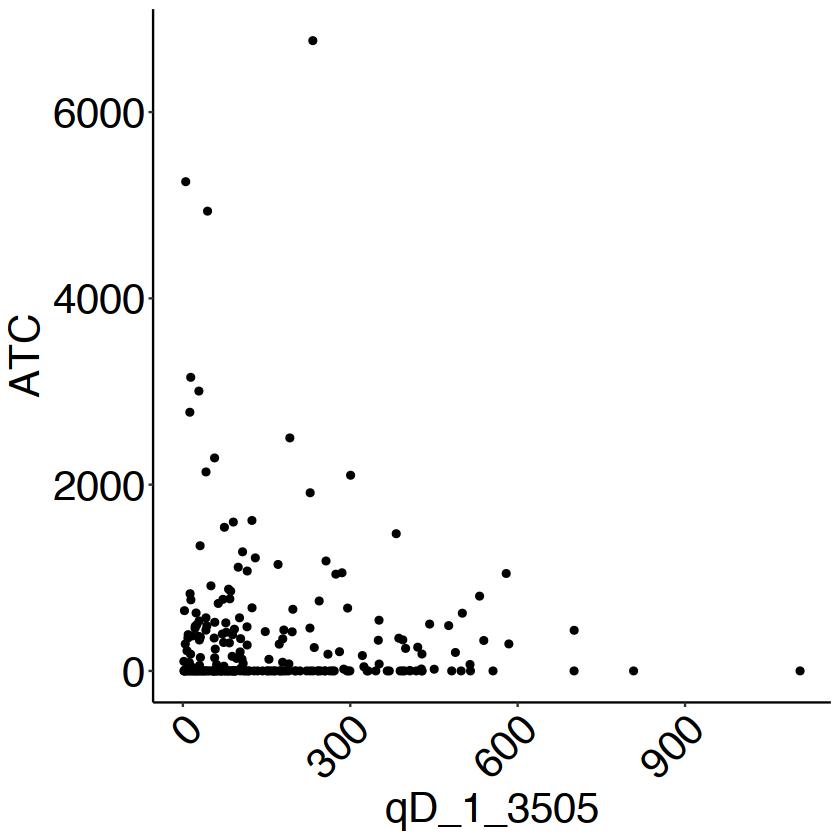

In [160]:
ggplot(data = pbmc_metadata_div, 
       aes( x = qD_1_3505, y = ATC) ) + geom_point() + myplot + myaxis

Subset to baseline

In [161]:
pbmc_metadata_div <- pbmc_metadata_div[ pbmc_metadata_div$Cycle %in% c(0,1),]

In [162]:
dim(pbmc_metadata_div)

[1] 69 32

In [163]:
table(pbmc_metadata_div$Disease_type)


  ALCL    ALL    AML   ARMS     BL    CML   ERMS    EWS     HB     HD HR ALL 
     1      8      5      1      2      2      2      3      2      3      7 
   LFS     NB Normal     OS  T-ALL  WILMS 
    10      2     14      4      2      1 

In [168]:
colnames(pbmc_metadata_div)

[1] "TRB"                "Reads"              "CPKR"              
 [4] "Average_reads"      "VMR"                "Max_reads"         
 [7] "Singletons"         "Doubletons"         "qD"                
[10] "Sample_Coverage"    "observed_Richness"  "estimated_Richness"
[13] "SE_Richeness"       "observed_Shannon"   "estimated_Shannon" 
[16] "SE_Shannon"         "observed_Simpson"   "estimated_Simpson" 
[19] "SE_Simpson"         "Sample"             "Group"             
[22] "Patient"            "Cycle"              "sample_id"         
[25] "qD_0_3505"          "qD_1_3505"          "qD_2_3505"         
[28] "Disease_type"       "cancergroup"        "FOLD"              
[31] "ATC"                "Age"

Warning message:
“Removed 24 rows containing missing values (geom_point).”


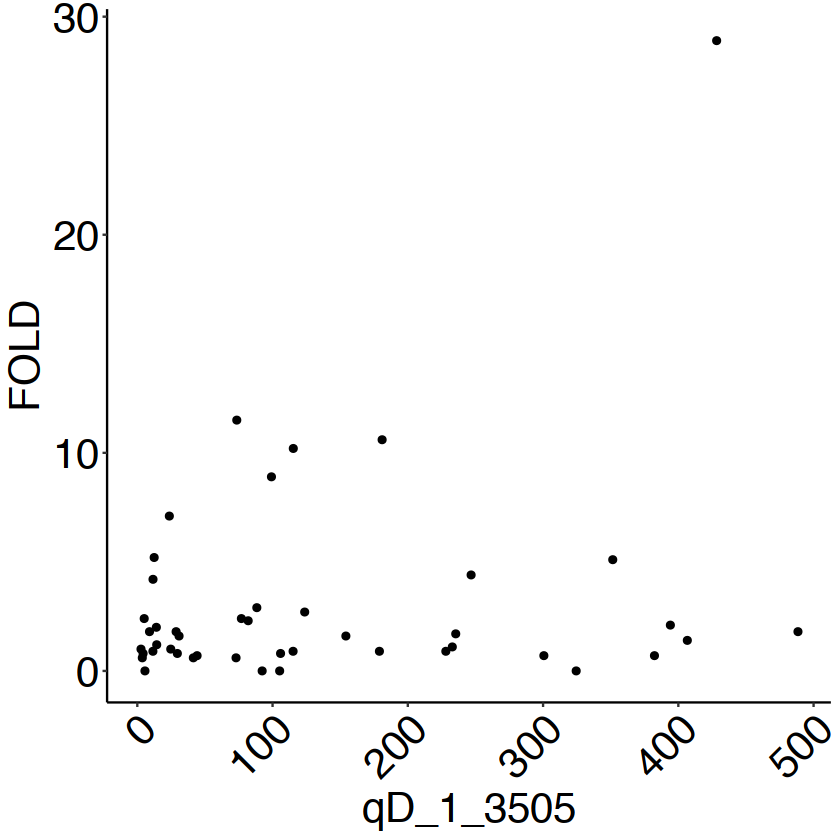

In [169]:
ggplot(data = pbmc_metadata_div, 
       aes( x = qD_1_3505, y = FOLD) ) + geom_point() + myplot + myaxis

In [63]:
myorder <- sort(tapply(pbmc_metadata_div$qD_1_3505, pbmc_metadata_div$Disease_type, median))

In [65]:
pbmc_metadata_div$Disease_type <- factor(pbmc_metadata_div$Disease_type, levels = names(myorder))

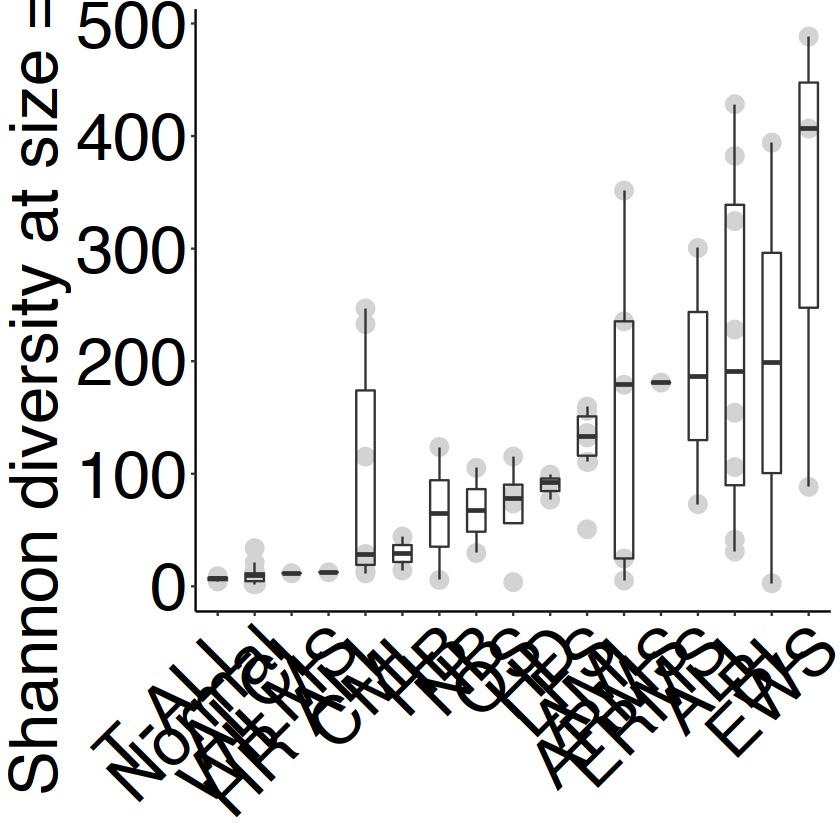

In [66]:
divplot_cohort <- ggplot(data = pbmc_metadata_div,
                 aes(x = Disease_type, y = qD_1_3505)) + 
geom_beeswarm(size = 5, color = "light grey", shape = 16, cex = 0.2) + 
geom_boxplot(width = 0.5, outlier.colour = NA, fill = NA) + 
myaxis + myplot +
scale_color_manual(values = cohort_col) +
theme(legend.position = "none", 
     axis.title.x = element_blank(),
     axis.title.y = element_text(size = 40),
     axis.text.x = element_text(size = 40),
      axis.text.y = element_text(size = 40),
     plot.title = element_text(size = 40, hjust = 0.5)) + 
labs(y = "Shannon diversity at size = 3505")
divplot_cohort

In [67]:
pdf(paste0(plotpath, "divplot_cohort.pdf"),
   width = 20, height = 10)
divplot_cohort
dev.off()

pdf 
  2

In [78]:
myorder <- sort(tapply(pbmc_metadata_div$qD_1_3505, pbmc_metadata_div$cancergroup, median))

In [79]:
myorder

Leukemia Lymphoma    Solid      LFS 
 75.0625  84.6305  88.3660 133.4735

In [80]:
pbmc_metadata_div$cancergroup <- factor(pbmc_metadata_div$cancergroup, levels = names(myorder))

In [103]:
wilcox.test(pbmc_metadata_div$qD_1_3505[ pbmc_metadata_div$cancergroup == "LFS"],
      pbmc_metadata_div$qD_1_3505[ pbmc_metadata_div$cancergroup == "Lymphoma"])


	Wilcoxon rank sum exact test

data:  pbmc_metadata_div$qD_1_3505[pbmc_metadata_div$cancergroup == "LFS"] and pbmc_metadata_div$qD_1_3505[pbmc_metadata_div$cancergroup == "Lymphoma"]
W = 47, p-value = 0.07268
alternative hypothesis: true location shift is not equal to 0


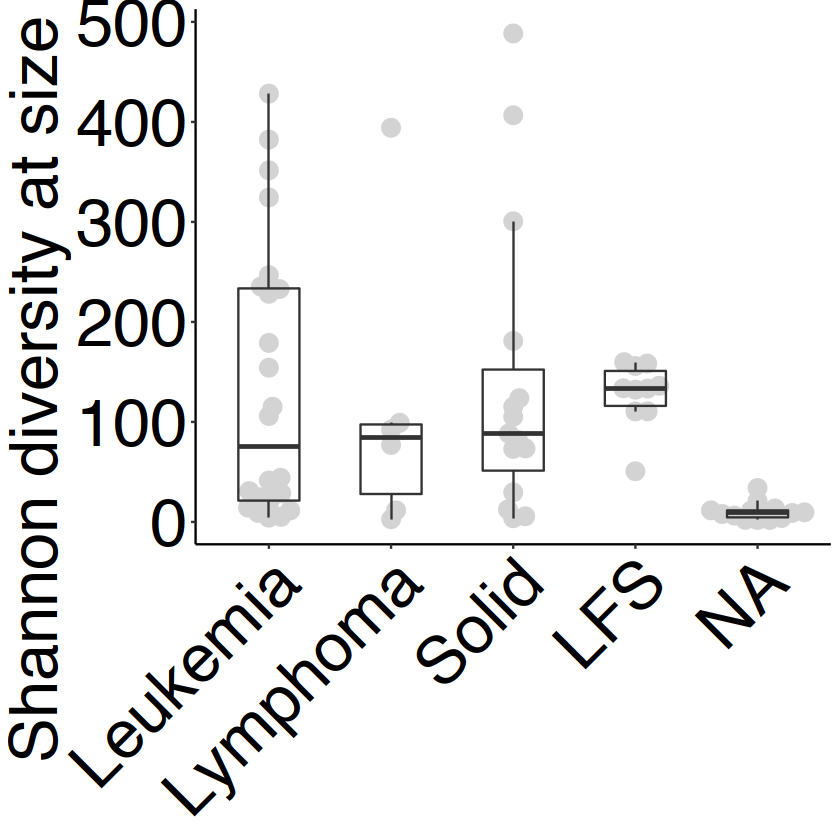

In [81]:
divplot_cancer <- ggplot(data = pbmc_metadata_div,
                 aes(x = cancergroup, y = qD_1_3505)) + 
geom_beeswarm(size = 5, color = "light grey", shape = 16, cex = 2) + 
geom_boxplot(width = 0.5, outlier.colour = NA, fill = NA) + 
myaxis + myplot +
scale_color_manual(values = cohort_col) +
theme(legend.position = "none", 
     axis.title.x = element_blank(),
     axis.title.y = element_text(size = 40),
     axis.text.x = element_text(size = 40),
      axis.text.y = element_text(size = 40),
     plot.title = element_text(size = 40, hjust = 0.5)) + 
labs(y = "Shannon diversity at size = 3505")
divplot_cancer

In [82]:
pdf(paste0(plotpath, "divplot_cancergroup.pdf"),
   width = 10, height = 10)
divplot_cancer
dev.off()

pdf 
  2

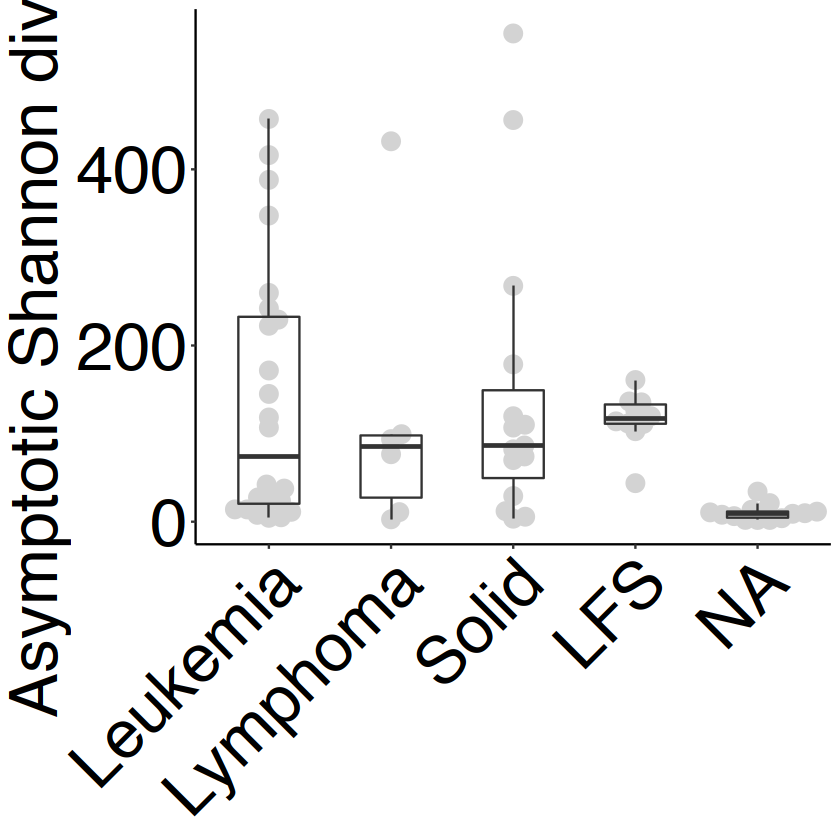

In [83]:
divplot_cancer <- ggplot(data = pbmc_metadata_div,
                 aes(x = cancergroup, y = observed_Shannon)) + 
geom_beeswarm(size = 5, color = "light grey", shape = 16, cex = 2) + 
geom_boxplot(width = 0.5, outlier.colour = NA, fill = NA) + 
myaxis + myplot +
scale_color_manual(values = cohort_col) +
theme(legend.position = "none", 
     axis.title.x = element_blank(),
     axis.title.y = element_text(size = 40),
     axis.text.x = element_text(size = 40),
      axis.text.y = element_text(size = 40),
     plot.title = element_text(size = 40, hjust = 0.5)) + 
labs(y = "Asymptotic Shannon diversity")
divplot_cancer

In [84]:
pdf(paste0(plotpath, "divplot_cancergroup_asymp.pdf"),
   width = 10, height = 10)
divplot_cancer
dev.off()

pdf 
  2

In [4]:
divstats <- read.csv(paste0(datapath, "capTCRseq/divstats_TRBCHP.csv"), header = T, stringsAsFactors = F, row.names = 1)

In [5]:
dim(divstats)

[1] 514  19

Separate samples

In [6]:
divstats$Sample <- NA
divstats$Sample[grepl("PBMC", rownames(divstats))] <- "PBMC"
divstats$Sample[grepl("cfDNA", rownames(divstats))] <- "cfDNA"
divstats$Sample[grepl("FFPE", rownames(divstats))] <- "Tumor"

Separate LFS and non-LFS

In [48]:
divstats$Group <- NA
divstats$Group[grepl("LFS", rownames(divstats))] <- "LFS"
divstats$Group[grepl("CHP", rownames(divstats))] <- "CHP"

In [10]:
tapply(divstats$TRB, divstats$Sample, summary)

$cfDNA
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    4.00    8.00   15.40   16.25  220.00 

$PBMC
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    2.0    55.0   146.0   253.5   352.0  2237.0 

$Tumor
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   2.00    5.00    9.00   37.71   75.00  145.00 


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



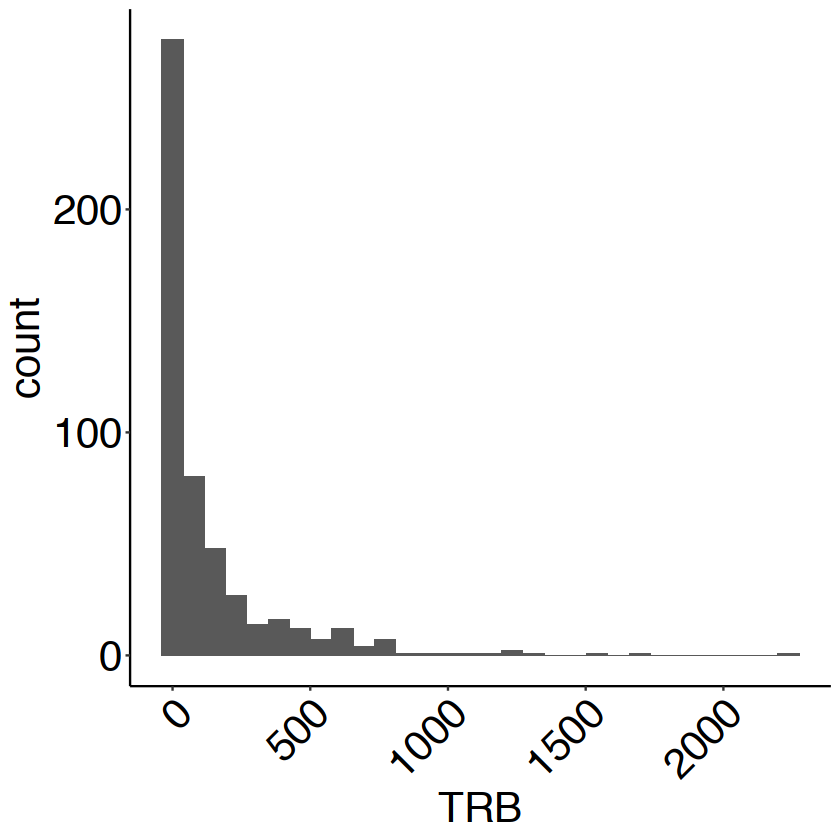

In [81]:
histp(divstats, "TRB")

Get patient ids

In [55]:
divstats$Patient <- NA
# CHP
divstats$Patient[divstats$Group == "CHP"] <- substr(rownames(divstats)[divstats$Group == "CHP"],1,7)
# Normal samples have either YO or MO
divstats$Patient[grepl("YO", rownames(divstats))] <- gsub("_PBMC_DNA", "", rownames(divstats)[grepl("YO", rownames(divstats))])
divstats$Patient[grepl("MO", rownames(divstats))] <- gsub("_PBMC_DNA", "", rownames(divstats)[grepl("MO", rownames(divstats))])
# LFS
divstats$Patient[divstats$Group == "LFS"] <- substr(rownames(divstats)[divstats$Group == "LFS"],1,12)

Get cycles. For LFS, Normals and Tumors recode to 00

In [56]:
divstats$Cycle <- NA
divstats$Cycle[divstats$Group == "CHP"] <- substr(rownames(divstats)[divstats$Group == "CHP"],9,10)

divstats$Cycle[grepl("YO", rownames(divstats))] <- "00"
divstats$Cycle[grepl("MO", rownames(divstats))] <- "00"
divstats$Cycle[ divstats$Sample == "Tumor"] <- "00"
divstats$Cycle[ divstats$Group == "LFS"] <- "00"

In [89]:
(table(divstats$Patient[ divstats$Sample == "PBMC"]))


  CHP_10YO-M   CHP_11YO-M CHP_15YO-F-A CHP_15YO-F-B   CHP_15YO-M   CHP_16YO-M 
           1            1            1            1            1            1 
 CHP_1YO-M-A  CHP_1YO-M-B    CHP_2YO-M      CHP_303      CHP_315      CHP_319 
           1            1            1            1            1            1 
     CHP_323      CHP_324      CHP_329      CHP_330      CHP_331      CHP_335 
           3            1            1            1            2            1 
     CHP_336      CHP_337      CHP_338      CHP_339      CHP_340      CHP_342 
           1            1            3            2            3            1 
     CHP_343      CHP_344      CHP_345      CHP_346      CHP_347      CHP_348 
           4            4            4            1            5            5 
     CHP_349      CHP_350      CHP_351      CHP_352      CHP_353      CHP_354 
           2            5            3            2            4            1 
     CHP_355      CHP_356      CHP_357      CHP_358

In [83]:
write.csv(divstats,
          paste0(datapath, "capTCRseq/divstats_TRBCHP.csv"), row.names = TRUE)

# Test dataset

In [13]:
file_list <- list.files(paste0(datapath, "capTCRseq/testdataset/"), pattern = "addjurkat", recursive = T)

file_list <- c(file_list, "CLONES_TRBA037.txt")

file_list <- file_list[!grepl("csv", file_list)]

test_immunelist <- immunelistfx(file_list, paste0(datapath, "capTCRseq/testdataset/"), "TRB")

number of clones in file:CLONES_TRBaddjurkat_112.75_0.25.txt



[1] 159


number of non prodcutive CDR3s:



[1] 0


nonproductive aaCDR3 removed

number of clones in file:CLONES_TRBaddjurkat_135.3_0.3.txt



[1] 149


number of non prodcutive CDR3s:



[1] 0


nonproductive aaCDR3 removed

number of clones in file:CLONES_TRBaddjurkat_157.85_0.35.txt



[1] 139


number of non prodcutive CDR3s:



[1] 0


nonproductive aaCDR3 removed

number of clones in file:CLONES_TRBaddjurkat_180.4_0.4.txt



[1] 126


number of non prodcutive CDR3s:



[1] 0


nonproductive aaCDR3 removed

number of clones in file:CLONES_TRBaddjurkat_202.95_0.45.txt



[1] 116


number of non prodcutive CDR3s:



[1] 0


nonproductive aaCDR3 removed

number of clones in file:CLONES_TRBaddjurkat_22.55_0.05.txt



[1] 195


number of non prodcutive CDR3s:



[1] 0


nonproductive aaCDR3 removed

number of clones in file:CLONES_TRBaddjurkat_225.5_0.5.txt



[1] 106


number of non prodcutive CDR3s:



[1] 0


nonproductive aaCDR3 removed

number of clones in file:CLONES_TRBaddjurkat_248.05_0.55.txt



[1] 98


number of non prodcutive CDR3s:



[1] 0


nonproductive aaCDR3 removed

number of clones in file:CLONES_TRBaddjurkat_270.6_0.6.txt



[1] 91


number of non prodcutive CDR3s:



[1] 0


nonproductive aaCDR3 removed

number of clones in file:CLONES_TRBaddjurkat_293.15_0.65.txt



[1] 78


number of non prodcutive CDR3s:



[1] 0


nonproductive aaCDR3 removed

number of clones in file:CLONES_TRBaddjurkat_315.7_0.7.txt



[1] 70


number of non prodcutive CDR3s:



[1] 0


nonproductive aaCDR3 removed

number of clones in file:CLONES_TRBaddjurkat_338.25_0.75.txt



[1] 61


number of non prodcutive CDR3s:



[1] 0


nonproductive aaCDR3 removed

number of clones in file:CLONES_TRBaddjurkat_360.8_0.8.txt



[1] 47


number of non prodcutive CDR3s:



[1] 0


nonproductive aaCDR3 removed

number of clones in file:CLONES_TRBaddjurkat_383.35_0.85.txt



[1] 39


number of non prodcutive CDR3s:



[1] 0


nonproductive aaCDR3 removed

number of clones in file:CLONES_TRBaddjurkat_405.9_0.9.txt



[1] 26


number of non prodcutive CDR3s:



[1] 0


nonproductive aaCDR3 removed

number of clones in file:CLONES_TRBaddjurkat_428.45_0.95.txt



[1] 14


number of non prodcutive CDR3s:



[1] 0


nonproductive aaCDR3 removed

number of clones in file:CLONES_TRBaddjurkat_45.1_0.1.txt



[1] 188


number of non prodcutive CDR3s:



[1] 0


nonproductive aaCDR3 removed

number of clones in file:CLONES_TRBaddjurkat_451_1.txt



[1] 1


number of non prodcutive CDR3s:



[1] 0


nonproductive aaCDR3 removed

number of clones in file:CLONES_TRBaddjurkat_67.65_0.15.txt



[1] 178


number of non prodcutive CDR3s:



[1] 0


nonproductive aaCDR3 removed

number of clones in file:CLONES_TRBaddjurkat_90.2_0.2.txt



[1] 169


number of non prodcutive CDR3s:



[1] 0


nonproductive aaCDR3 removed

number of clones in file:CLONES_TRBA037.txt



[1] 256


number of non prodcutive CDR3s:



[1] 55


nonproductive aaCDR3 removed



In [14]:
divstats_test <- read.csv(paste0(datapath, "capTCRseq/testdataset/divstats_TRBaddjurkat.csv"), 
                          header = T, stringsAsFactors = F, row.names = 1)

In [15]:
divstats_test

,TRB,Reads,CPKR,Average_reads,VMR,Max_reads,Singletons,Doubletons,qD,Sample_Coverage,observed_Richness,estimated_Richness,SE_Richeness,observed_Shannon,estimated_Shannon,SE_Shannon,observed_Simpson,estimated_Simpson,SE_Simpson
,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
addjurkat_112.75_0.25,159,452,351.769912,2.842767,3.0917208,112,58,44,188.784,0.972,159,197.143,13.097,71.158,91.250,7.381,15.145,15.635,2.446
addjurkat_135.3_0.3,149,453,328.918322,3.040268,3.6000507,135,54,42,176.332,0.975,149,183.638,12.332,55.794,70.304,5.980,10.740,10.977,1.562
addjurkat_157.85_0.35,139,451,308.203991,3.244604,4.0642777,157,51,40,164.687,0.977,139,171.440,11.887,43.327,53.823,4.720,7.989,8.115,1.040
addjurkat_180.4_0.4,126,451,279.379157,3.579365,4.4382934,180,45,35,148.777,0.979,126,154.864,11.257,32.830,39.916,3.531,6.134,6.205,0.675
addjurkat_202.95_0.45,116,451,257.206208,3.887931,4.7816386,202,41,32,136.710,0.981,116,142.207,10.709,25.357,30.335,2.896,4.901,4.944,0.481
addjurkat_22.55_0.05,195,451,432.372506,2.312821,0.8177325,22,72,51,233.424,0.961,195,245.711,15.621,158.226,215.800,9.032,117.099,157.815,14.306
addjurkat_225.5_0.5,106,451,235.033259,4.254717,5.0942701,225,38,28,125.840,0.981,106,131.729,10.911,19.284,22.763,2.549,3.969,3.995,0.366
addjurkat_248.05_0.55,98,452,216.814159,4.612245,5.3912300,248,37,27,117.423,0.981,98,123.296,10.871,14.750,17.228,2.000,3.292,3.309,0.282
addjurkat_270.6_0.6,91,453,200.883002,4.978022,5.6473161,270,36,26,110.007,0.981,91,115.868,10.834,11.444,13.243,1.452,2.796,2.808,0.227


Number of reads are the same just for test set endpoint to 550

In [16]:
#just order them
test_immunelist <- test_immunelist[c('A037','addjurkat_22.55_0.05','addjurkat_45.1_0.1',
                                   'addjurkat_67.65_0.15','addjurkat_90.2_0.2',
                                   'addjurkat_112.75_0.25','addjurkat_135.3_0.3','addjurkat_157.85_0.35',
                                   'addjurkat_180.4_0.4','addjurkat_202.95_0.45',
                                   'addjurkat_225.5_0.5','addjurkat_248.05_0.55','addjurkat_270.6_0.6',
                                   'addjurkat_293.15_0.65','addjurkat_315.7_0.7','addjurkat_338.25_0.75',
                                   'addjurkat_360.8_0.8','addjurkat_383.35_0.85','addjurkat_405.9_0.9',
                                   'addjurkat_428.45_0.95','addjurkat_451_1')]

In [17]:
out_testdata <- safe_mclapply(1:length(test_immunelist), 
                     function(x){ iNEXT(test_immunelist[x], c(0,1,2), 
                                        datatype="abundance", nboot = 50, endpoint = 550)}, mc.cores = 4)

In [18]:
save(out_testdata, file = paste0(datapath, "capTCRseq/testdataset/testdata_inextout.RData"))

# Load iNEXT output for testdata

In [36]:
load(file = paste0(datapath,"capTCRseq/testdataset/testdata_inextout.RData"))

In [37]:
length(out_testdata)

[1] 21

get sample names

In [38]:
testallnames <- names(out_testdata[[1]]$iNextEst)

for(i in 2:length(out_testdata)){
    testallnames <- c(testallnames, names(out_testdata[[i]]$iNextEst))
}

make a list of plots

In [39]:
testlistofplots <- lapply(c(1:length(out_testdata)), function(x){ 
    p <- ggiNEXT(out_testdata[[x]], type=1, color.var ="order") + 
    theme_bw(base_size = 10) + labs(title = testallnames[x]) +
theme(plot.title = element_text(size = 5,hjust = 0.5),
     legend.position = "none")})

In [40]:
names(testlistofplots) <- testallnames

In [41]:
names(testlistofplots)

[1] "A037"                  "addjurkat_22.55_0.05"  "addjurkat_45.1_0.1"   
 [4] "addjurkat_67.65_0.15"  "addjurkat_90.2_0.2"    "addjurkat_112.75_0.25"
 [7] "addjurkat_135.3_0.3"   "addjurkat_157.85_0.35" "addjurkat_180.4_0.4"  
[10] "addjurkat_202.95_0.45" "addjurkat_225.5_0.5"   "addjurkat_248.05_0.55"
[13] "addjurkat_270.6_0.6"   "addjurkat_293.15_0.65" "addjurkat_315.7_0.7"  
[16] "addjurkat_338.25_0.75" "addjurkat_360.8_0.8"   "addjurkat_383.35_0.85"
[19] "addjurkat_405.9_0.9"   "addjurkat_428.45_0.95" "addjurkat_451_1"

In [42]:
pdf(paste0(plotpath, "testdata_all_plots.pdf"),
   width = 10, height = 10)
plot_grid(plotlist = testlistofplots, ncol = 5)
dev.off()

pdf 
  2

# 3D plot from TJP

In [ ]:
# load the plotly R package
library(plotly)

# Synthetic data from 1-100
len <- 10
lim <- 10
xseries <- (seq(0, lim, by = lim/len))
yseries <- (seq(0, lim, by = lim/len)^2)
zseries <- (seq(0, lim, by = lim/len)^2)
sizes <- xseries * 4

#Set up 3D plot
fig <- plot_ly( x = xseries, y = yseries, z = zseries,
				type="scatter3d",
				mode="markers",
				marker = list(size = sizes, opacity=0)
			)

#Add axis curves
add_trace(fig, x=xseries, y=yseries, z=0, type = 'scatter3d', mode = 'lines', marker = list(size = 0.000001)) %>%
add_trace(fig, x=xseries, y=100, z=zseries, type = 'scatter3d', mode = 'lines', marker = list(size = 0.000001)) %>%
add_trace(fig, x=0, y=yseries, z=zseries, type = 'scatter3d', mode = 'lines', marker = list(size = 0.000001))

#Display the resulting figure
fig